# Best Pokemon Team EVER

When I was younger, I discover the pokemon universe by playing "Pokemon Diamond" on Nintendo DS. And before catching a pokemon, I always ask myself : "Is this pokemon going to make my team stronger ?". Because your team is limited. You can only have 6 pokemon at max, so you have to choose which pokemon goes on your team carefully.

At that time I only choose pokemon who looks strong or had capabilities that I thought were strong. Today I will, once and for all, takle the question **"What are the best 6 pokemons to have on your team to beat every other player ?"** by looking at the actual data of the pokemon!

## Pokemon theory

If you're not familiar with the way of how pokemon works, each pokemon have a type. There are grass pokemon, fire pokemon, water pokemon, etc... One type can beats other types and are beaten by other other types. For example; plant pokemon are weak against fire pokemon, which in turn are weak against water pokmon which in turn are weak against plant pokemon. This is the weakness system.

This system can be complex, this is how it's implemented in pokemon :

<p align="center">
  <img width="460" height="300" src="http://www.gamesprecipice.com/wp-content/uploads/2014/01/pokemon.png">
</p>

A pokemon has also other characteristics that are not specific to it's type (health, attack...).

### PokeMath

The formulae to calculate the amount of damage that a pokemon deal can be found [here](https://pokemon.fandom.com/wiki/Damage_Calculation).

In order to define is a pokemon is better than another we will introduce a metrics which count the number of turns that a pokemon would be able to stand against an opponent. Because I want to capture if a pokemon might be able to beat two other pokemon.

In this document I will assume that pokemons are only using their basic attack and no object. It will make the calculation much simpler.

This ‘turns that a pokemon lasts’ metric is defined by the following formulae:
$$T_{ij} = \frac{HP_{i}}{DMG_{ji}}$$
where:
- $T_{ij}$ is the number of turns that pokemon $i$ will survive to the opponent $j$ if it were to be attacked indefinately.
- $HP_i$ is the amount of health point that pokemon $i$ has.
- $DMG_{ji}$ is the amount of damage that a basic attack of pokemon $j$ would deal to pokemon $i$.

$DMG_{ji}$ is defined as follow:
$$DMG_{ji} = \frac{2 \times Level_j + 10}{250} \times \frac{Attack_j}{Defense_i} \times w_{ji}$$
where:
- $Level_a$ is the level of the pokemon $a$.
- $Attack_a$ is the attack power of pokemon $a$.
- $Defense_a$ is the defensive power od pokemon $a$.
- $w_{ab}$ is the weakness coefficient between pokemon $a$ and $b$.

## Some code

### Setup the environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Data come from https://www.kaggle.com/rounakbanik/pokemon
df = pd.read_csv("C:/Users/Paul Eudeline/workspace/best_pokemon_team/pokemon.csv")

def loggg(f):
    def wrapper(dataframe, *args, **kwargs):
        after_f_dataframe = f(dataframe, *args, **kwargs)
        print(f'After {f.__name__}(), dataframe shape is {after_f_dataframe.shape}')
        return after_f_dataframe
    return wrapper

@loggg
def init_pipe(dataframe):
    return dataframe.copy()

@loggg
def clean_data(dataframe, n=40):
    weakness_dataframe = dataframe.filter(regex='^against_').rename(columns={'against_fight': 'against_fighting'})
    pokemon_dataframe = dataframe[["name", "type1", "type2", "attack", "defense", "hp"]]
    return pd.concat([pokemon_dataframe, weakness_dataframe], axis=1).iloc[:n].drop_duplicates().fillna(False)

df_pokemon = (df
              .pipe(init_pipe)
              .pipe(clean_data, n=151)
             )

df_pokemon_sort_by_type = df_pokemon.sort_values(['type1', 'type2'])

After init_pipe(), dataframe shape is (801, 41)
After clean_data(), dataframe shape is (151, 24)


### Compute the number of turns that a pokemon stands against another

In [4]:
# We say level always = 100
pokemon_level = 100

def fight(pokemon_i, pokemon_j, debug=False):
    """It calculates the number of turns that pokemon i can stand against pokemon j"""
    attack_j = df_pokemon.at[pokemon_j, 'attack']
    
    hp_i = df_pokemon.at[pokemon_i, 'hp']
    defense_i = df_pokemon.at[pokemon_i, 'defense']
    type1_j = df_pokemon.at[pokemon_j, 'type1']
    type2_j = df_pokemon.at[pokemon_j, 'type2']
        
    if type2_j:
        weakness_factor = max(
            df_pokemon.at[pokemon_i, f'against_{type1_j}'],
            df_pokemon.at[pokemon_i, f'against_{type2_j}']
        )
    else:
        weakness_factor = df_pokemon.at[pokemon_i, f'against_{type1_j}']
        
    dmg_ji = ((2 * pokemon_level + 10) / 250) * 80 * (attack_j / defense_i) * weakness_factor
    if dmg_ji == 0: return np.NaN
    
    if debug: print(f"{df_pokemon.at[pokemon_i, 'name']} can last {hp_i / dmg_ji} turns againt {df_pokemon.at[pokemon_j, 'name']}")
    return hp_i / dmg_ji

In [31]:
n_pokemon = df_pokemon.shape[0]
n_turn_matrix = pd.DataFrame(
    np.zeros((n_pokemon, n_pokemon)),
    index=df_pokemon['name'],
    columns=df_pokemon['name']
)

for pokemon_i in df_pokemon.index:
    for pokemon_j in df_pokemon.index:            
        n_turn_matrix.at[df_pokemon.at[pokemon_i, 'name'], df_pokemon.at[pokemon_j, 'name']] = fight(pokemon_i, pokemon_j)

### Show the results

In [29]:
def draw_fight_matrix(matrix):
    fig, ax = plt.subplots(figsize = (50, 50))
    im = ax.imshow(matrix.values, cmap=plt.get_cmap("RdYlGn", 30))

    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(df_pokemon.shape[0]))
    ax.set_yticks(np.arange(df_pokemon.shape[0]))
    # ... and label them with the respective list entries
    ax.set_xticklabels(matrix.columns)
    ax.set_yticklabels(matrix.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    ax.set_title("Matrix of battles between pokemons")
    fig.tight_layout()
    plt.savefig("pokemon_comparator.jpeg")
    plt.show()

A green cell indicates that the row will win from the column, a red cell indicates that the row will loose.

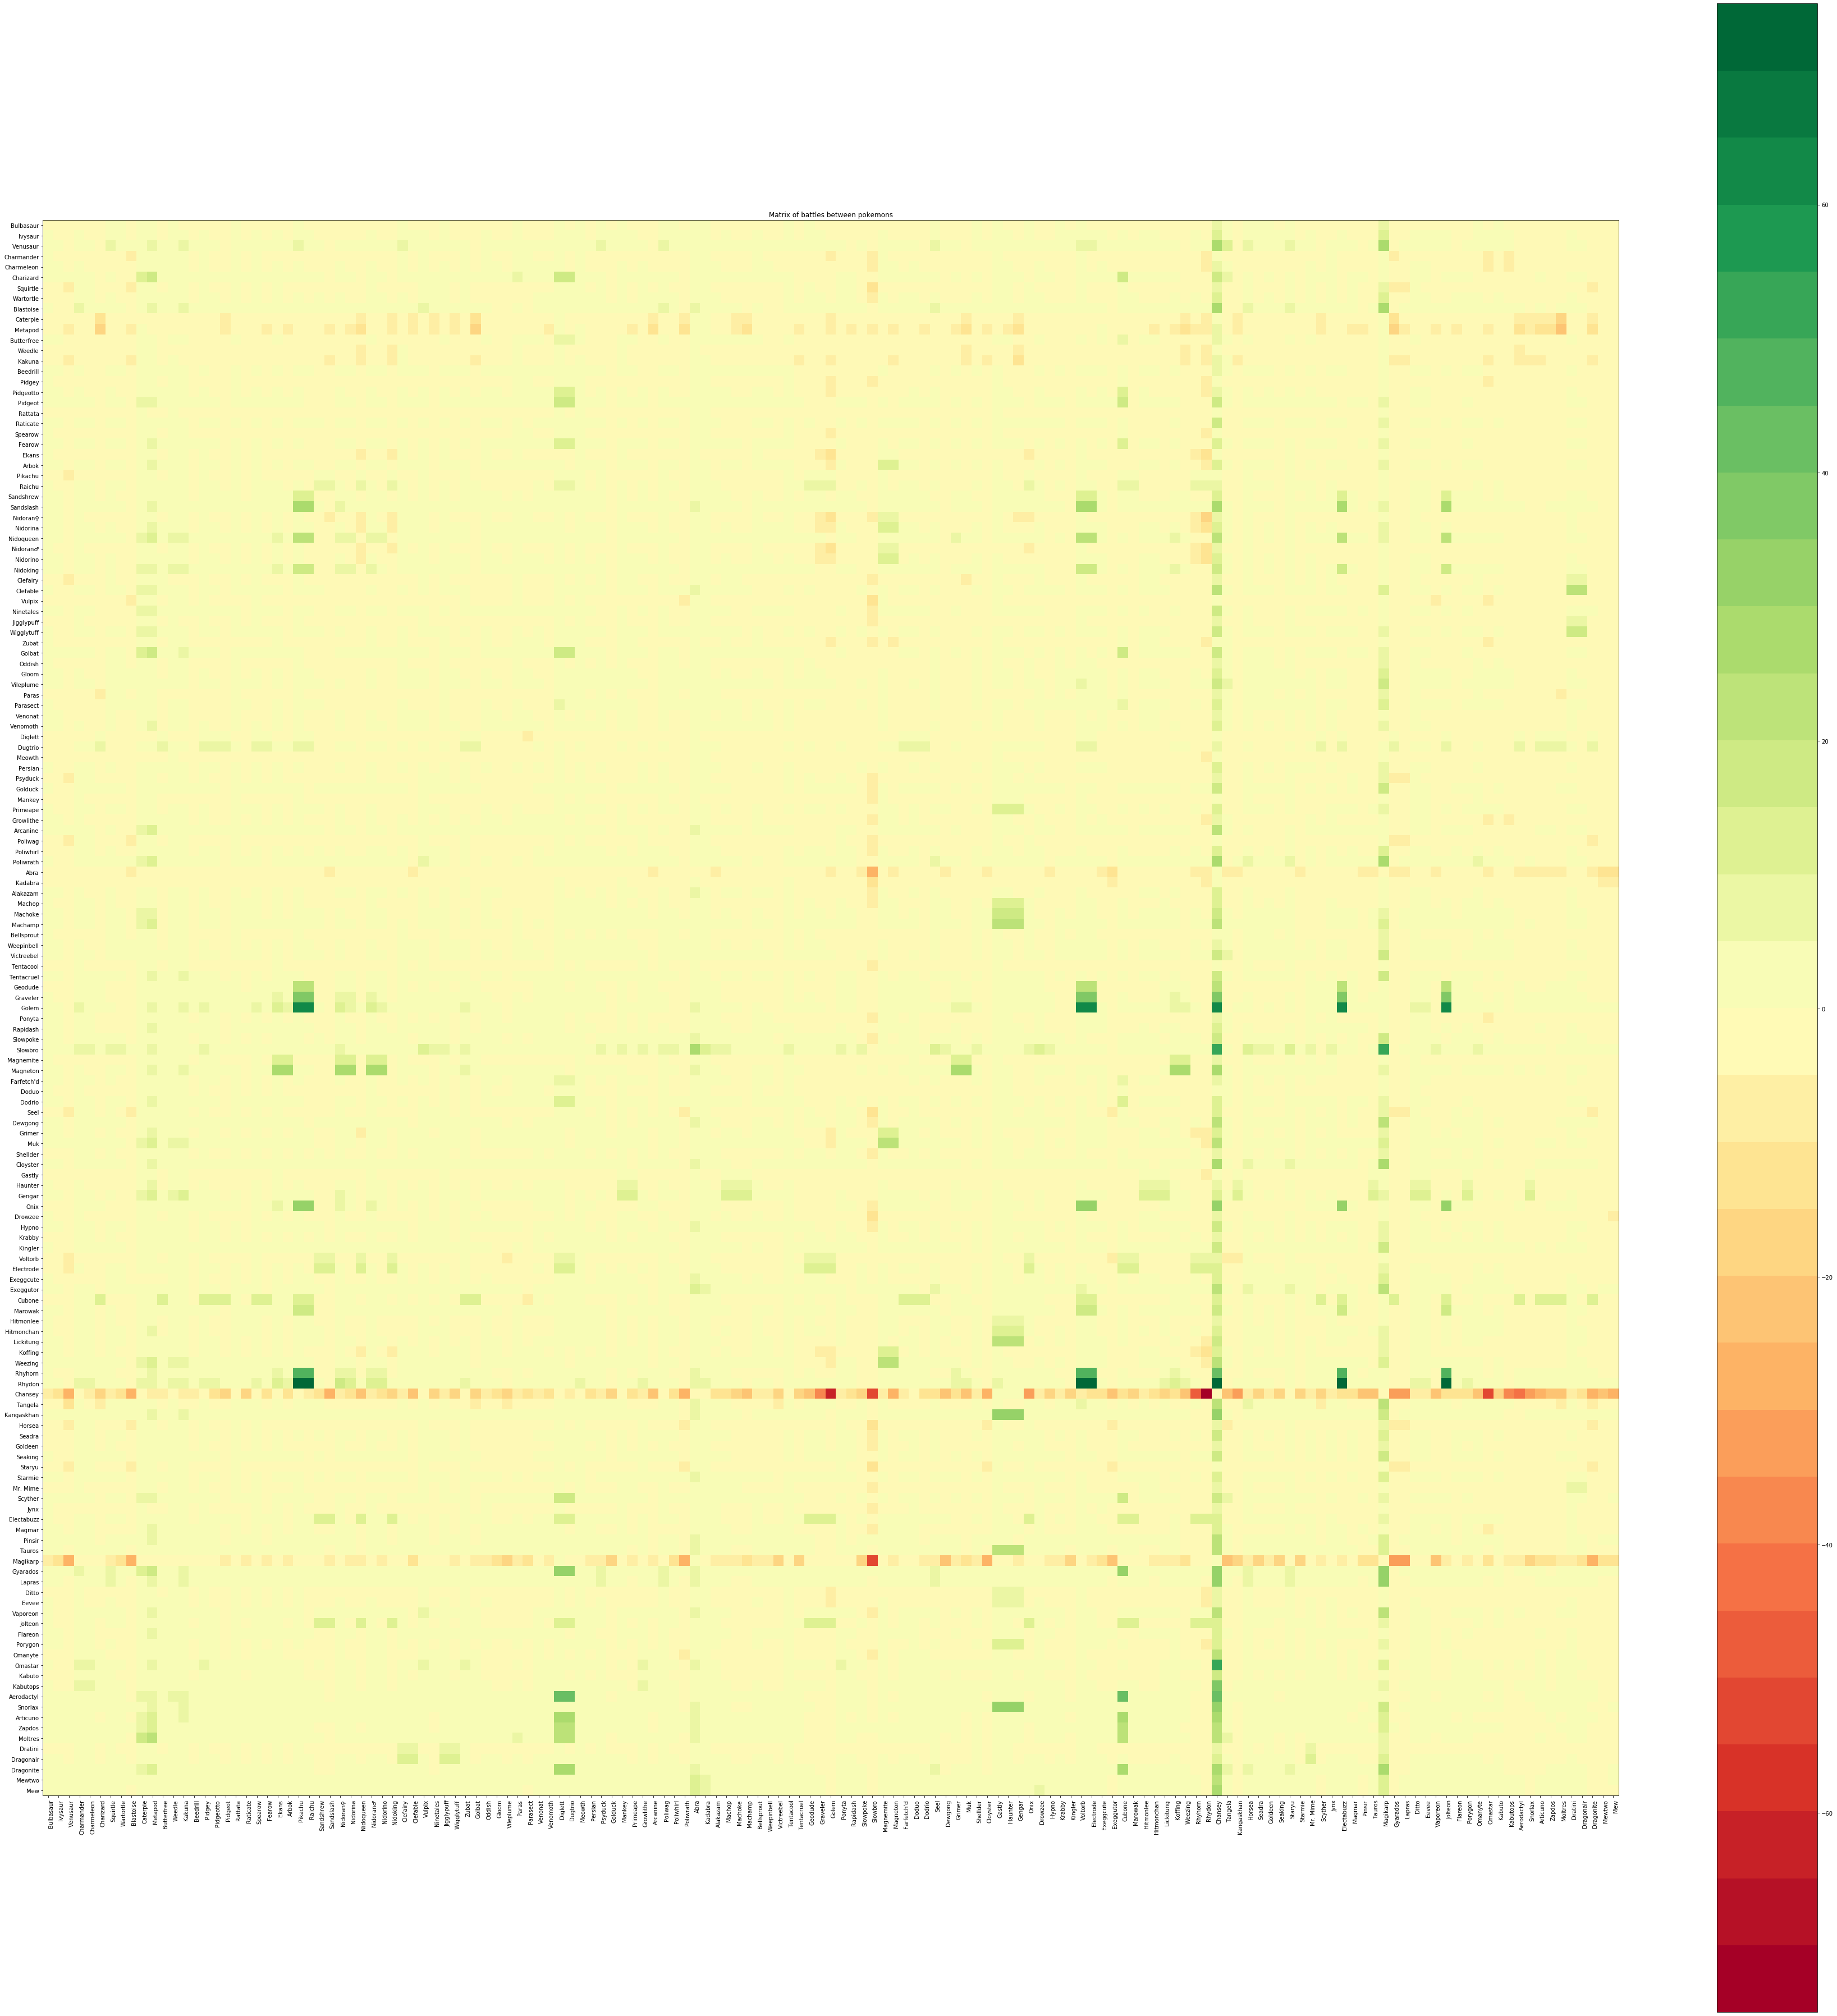

In [50]:
# When the pokemon can't be beat, we replace the number of turns by
# the maximum number of turns that he can do
#n_turn_matrix = np.log(n_turn_matrix).fillna(n_turn_matrix.T.max())

power_matrix = (n_turn_matrix - n_turn_matrix.T).T.fillna(n_turn_matrix.T.max()).T
draw_fight_matrix(power_matrix)

Immediately you should be able to see that a few pokemon will rarely win (this corresponds to a horizontal red line).

## I want to be the very best

Now I need to choose the 6 best pokemon. I can choose by sorting them with the number of turns then will win in average.

In [60]:
compare = pd.concat([
    power_matrix.T.mean(),
    power_matrix.T.std(),
    power_matrix.T.median()
    ], axis=1).rename(columns={0: 'Mean', 1: 'Std', 2: 'Median'})
compare.sort_values(['Mean'], ascending=False).head(15)

,Mean,Std,Median
name,,,
Rhydon,6.042127,15.568388,1.762821
Golem,4.889283,12.877327,1.350889
Slowbro,4.455876,6.321727,3.200549
Gyarados,3.367888,5.466171,2.153636
Rhyhorn,3.293014,9.491137,0.584296
Magneton,2.735697,7.353758,0.547094
Graveler,2.704298,7.909683,0.478614
Dragonite,2.677486,4.664183,1.579380
Kangaskhan,2.625131,5.062260,1.575704


But I also need to choose a pokemon that can beat a maximum number of other pokemon.

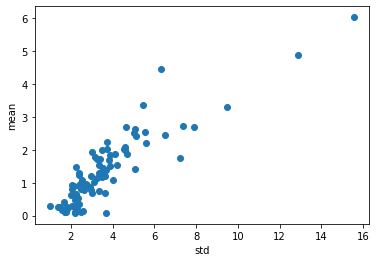

In [61]:
c = compare[compare['Mean'] > 0]
plt.scatter(c['Std'], c['Mean'])
plt.xlabel("std")
plt.ylabel("mean")
plt.show()

So this is a tradeoff between the mean and the variance.

## My team :

In [63]:
team = compare.sort_values(['Mean', 'Std'], ascending=False).head(12).sort_values('Std', ascending=True).head(6)
team

,Mean,Std,Median
name,,,
Dragonite,2.677486,4.664183,1.579380
Snorlax,2.511381,5.040923,1.469518
Kangaskhan,2.625131,5.062260,1.575704
Gyarados,3.367888,5.466171,2.153636
Sandslash,2.543762,5.548039,1.134105
Slowbro,4.455876,6.321727,3.200549


<div>
    <img src="https://www.pokepedia.fr/images/8/87/Dracolosse-RFVF.png" width=100 height=100 title=Dragonite />
    <img src="https://www.pokepedia.fr/images/2/2b/Ronflex-RFVF.png" width=100 height=100 title=Snorlax />
    <img src="https://www.pokepedia.fr/images/7/78/Kangourex-RFVF.png" width=100 height=100 title=Kangaskhan />
    <img src="https://www.pokepedia.fr/images/f/f2/L%C3%A9viator-RFVF.png" width=100 height=100 title=Gyarados />
    <img src="https://www.pokepedia.fr/images/a/a1/Sablaireau-RFVF.png" width=100 height=100 title=Sandslash />
    <img src="https://www.pokepedia.fr/images/b/b4/Flagadoss-RFVF.png" width=100 height=100 title=Slowbro />
</div>